Import libraries:

In [85]:
import pandas as pd
import numpy as np
import os 
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib

List of files to be imported. glob glob will read all the txt:

In [86]:
#files to read:
files = glob.glob(os.path.join(os.getcwd(),'*cement*.txt')) 
#print:
[i.split("\\")[-1] for i in files]

['cement0place_temp20at120fw_rem216.txt',
 'cement0place_temp20at120fw_rem72.txt',
 'cement0place_temp20at144fw_rem216.txt',
 'cement0place_temp20at144fw_rem72.txt',
 'cement0place_temp20at168fw_rem216.txt',
 'cement0place_temp20at168fw_rem72.txt',
 'cement0place_temp20at192fw_rem216.txt',
 'cement0place_temp20at192fw_rem72.txt',
 'cement0place_temp20at1fw_rem216.txt',
 'cement0place_temp20at1fw_rem72.txt',
 'cement0place_temp20at216fw_rem216.txt',
 'cement0place_temp20at216fw_rem72.txt',
 'cement0place_temp20at72fw_rem216.txt',
 'cement0place_temp20at72fw_rem72.txt',
 'cement0place_temp20at96fw_rem216.txt',
 'cement0place_temp20at96fw_rem72.txt',
 'cement0place_temp28at120fw_rem216.txt',
 'cement0place_temp28at120fw_rem72.txt',
 'cement0place_temp28at144fw_rem216.txt',
 'cement0place_temp28at144fw_rem72.txt',
 'cement0place_temp28at168fw_rem216.txt',
 'cement0place_temp28at168fw_rem72.txt',
 'cement0place_temp28at192fw_rem216.txt',
 'cement0place_temp28at192fw_rem72.txt',
 'cement0pla

Read data:

In [87]:
keymap_list = []
for idx,i in enumerate(files):
    with open(i, 'r') as f:
        file_lines = f.readlines()
    keymap_list.append(pd.DataFrame([string.split('\t') for string in file_lines]))
    keymap_list[idx].loc[:,"File"] = i.split("\\")[-1]
keymap = pd.concat(keymap_list)

Clean data:

In [88]:
keymap.iloc[:,0].where(keymap.iloc[:,0].str.contains("Time Step"),inplace = True)
keymap.iloc[:,0].fillna(method='ffill',inplace = True)
keymap.dropna(axis=0, how="any",inplace = True)
keymap.iloc[:,0] = keymap.iloc[:,0].str.split(" ").apply(lambda x: (x[-1]))
keymap.iloc[0,0] = "Time"
keymap = keymap.drop(keymap.index[0]).reset_index(drop = True)
cols = ["Time [h]", "Node", "X [m]", "Y [m]", "Z [m]", "Temp [C]", "File"]
keymap.columns = cols
keymap = (pd.merge(keymap.loc[:,keymap.columns != "File"].apply(pd.to_numeric, errors='coerce'),
                  keymap.loc[:,keymap.columns == "File"], left_index = True, right_index = True)
            .dropna()
            .reset_index(drop = True))

In [89]:
#search for integers in a string (text naming) and 
keymap_file_ID = pd.DataFrame(
    keymap.loc[:,"File"].apply(lambda x: re.findall("[-+]?\d*\.\d+|\d+", x)).tolist(), 
    columns=['Cement ID', 'Placing Temperature [C]', '2nd pour time [h]',"Fw removed a/ 2nd pr time [h]"]
)

keymap = pd.concat([keymap, keymap_file_ID.astype(float)], axis=1)

Add feature, cement ID, placing temperature and 2nd pouring time

In [90]:
keymap["Fw removed a/ 2nd pr time [h]"].unique()

array([216.,  72.])

In [91]:
#Categorize the feature. whether is 1st or 2nd pour for the 3D module
#get the nodes between 0 and 3
keymap = keymap.loc[keymap.loc[:,"Y [m]"].between(0, 3.01),:]

#get the framework removed at 2nd
#keymap = keymap.loc[keymap.loc[:,"Fw removed a/ 2nd pr time [h]"] == 336.0,:]

#label 1st and 2nd pour taking into account time:
keymap.loc[:,"2nd pour"] = np.nan
keymap.loc[keymap.loc[:,"Time [h]"] <= keymap.loc[:,"2nd pour time [h]"],"2nd pour"] = "Before"
keymap.loc[keymap.loc[:,"Time [h]"] > keymap.loc[:,"2nd pour time [h]"],"2nd pour"] = "After"

#label 1st and 2nd pour taking into account dimensional feature:
keymap.loc[:,"Feature"] = np.nan
keymap.loc[keymap.loc[:,"Y [m]"].between(0, 1.51),"Feature"] = "1st Pour"
keymap.loc[keymap.loc[:,"Y [m]"].between(1.51, 3.01),"Feature"] = "2nd Pour"
keymap.dropna(axis=0, how='any',inplace=True)


#Categorize the feature. whether is 1st, 2nd pour or corbel for the 3D model
#keymap.loc[keymap.loc[:,"Z [m]"].between(-3.12794, -1.62795),"Feature"] = "1st Pour"
#keymap.loc[keymap.loc[:,"Z [m]"] > -1.62795,"Feature"] = "2nd Pour"
#keymap.loc[keymap.loc[:,"Z [m]"] < -3.12794,"Feature"] = "corbel"
#keymap.head()

In [92]:
keymap

,Time [h],Node,X [m],Y [m],Z [m],Temp [C],File,Cement ID,Placing Temperature [C],2nd pour time [h],Fw removed a/ 2nd pr time [h],2nd pour,Feature
320,0.0,321.0,0.00,0.00,0.0,15.0000,cement0place_temp20at120fw_rem216.txt,0.0,20.0,120.0,216.0,Before,1st Pour
321,0.0,322.0,0.16,0.00,0.0,15.0000,cement0place_temp20at120fw_rem216.txt,0.0,20.0,120.0,216.0,Before,1st Pour
322,0.0,323.0,0.32,0.00,0.0,15.0000,cement0place_temp20at120fw_rem216.txt,0.0,20.0,120.0,216.0,Before,1st Pour
323,0.0,324.0,0.48,0.00,0.0,15.0000,cement0place_temp20at120fw_rem216.txt,0.0,20.0,120.0,216.0,Before,1st Pour
324,0.0,325.0,0.64,0.00,0.0,15.0000,cement0place_temp20at120fw_rem216.txt,0.0,20.0,120.0,216.0,Before,1st Pour
325,0.0,326.0,0.80,0.00,0.0,15.0000,cement0place_temp20at120fw_rem216.txt,0.0,20.0,120.0,216.0,Before,1st Pour
326,0.0,327.0,0.96,0.00,0.0,15.0000,cement0place_temp20at120fw_rem216.txt,0.0,20.0,120.0,216.0,Before,1st Pour
327,0.0,328.0,1.12,0.00,0.0,15.0000,cement0place_temp20at120fw_rem216.txt,0.0,20.0,120.0,216.0,Before,1st Pour
328,0.0,329.0,1.28,0.00,0.0,15.0000,cement0place_temp20at120fw_rem216.txt,0.0,20.0,120.0,216.0,Before,1st Pour
329,0.0,330.0,1.44,0.00,0.0,15.0000,cement0place_temp20at120fw_rem216.txt,0.0,20.0,120.0,216.0,Before,1st Pour


In [93]:
# #Max absolute temperature for 1st pour:
# keymap_1st = keymap.loc[keymap.loc[:,"Time [hours]"]<=keymap.loc[:,"2nd pouring time [hours]"],:]
# idx1 = keymap_1st.groupby(['File'])['Temp [C]'].transform(max) == keymap_1st['Temp [C]']
# keymap_1st[idx1].drop_duplicates(subset=['Node', 'Temp [C]', "File"], keep="first")

In [94]:
# #Max absolute temperature for 2nd pour:
# keymap_2nd = keymap.loc[keymap.loc[:,"Time [hours]"]>keymap.loc[:,"2nd pouring time [hours]"],:]
# idx2 = keymap_2nd.groupby(['File'])['Temp [C]'].transform(max) == keymap_2nd['Temp [C]']
# keymap_2nd[idx2].drop_duplicates(subset=['Node', 'Temp [C]', "File"], keep="first")

Calculate maximum temperature:

In [95]:
#Max absolute temperature for 1st and 2nd pour:
                         
#function max_min_idx
def max_min_idx(df, max_or_min,by_columns,on_columns):
    return df.groupby(by_columns)[on_columns].transform(max_or_min) == df[on_columns]

#index for 1st and 2nd pour:
idx_max = max_min_idx(keymap, max, ['File',"Feature"], 'Temp [C]')

#max temperature dataframe
keymap_maxT = (keymap[idx_max]
               .sort_values(by=["Cement ID",
                                "Placing Temperature [C]",
                                "Fw removed a/ 2nd pr time [h]",
                                "2nd pour time [h]",
                                "Feature"
                               ]
                           )
               .reset_index(drop=True)
              )

#print
keymap_maxT.set_index("File").head(16)

,Time [h],Node,X [m],Y [m],Z [m],Temp [C],Cement ID,Placing Temperature [C],2nd pour time [h],Fw removed a/ 2nd pr time [h],2nd pour,Feature
File,,,,,,,,,,,,
cement0place_temp20at1fw_rem72.txt,115.1950,458.0,1.44,1.20,0.0,76.8589,0.0,20.0,1.0,72.0,After,1st Pour
cement0place_temp20at1fw_rem72.txt,96.9363,507.0,1.60,1.65,0.0,75.5664,0.0,20.0,1.0,72.0,After,2nd Pour
cement0place_temp20at72fw_rem72.txt,167.9360,490.0,1.44,1.50,0.0,73.9396,0.0,20.0,72.0,72.0,After,1st Pour
cement0place_temp20at72fw_rem72.txt,113.5300,553.0,1.28,2.10,0.0,80.5053,0.0,20.0,72.0,72.0,After,2nd Pour
cement0place_temp20at96fw_rem72.txt,191.9360,490.0,1.44,1.50,0.0,71.2518,0.0,20.0,96.0,72.0,After,1st Pour
cement0place_temp20at96fw_rem72.txt,137.5300,553.0,1.28,2.10,0.0,79.6593,0.0,20.0,96.0,72.0,After,2nd Pour
cement0place_temp20at120fw_rem72.txt,71.4967,379.0,1.60,0.45,0.0,71.0848,0.0,20.0,120.0,72.0,Before,1st Pour
cement0place_temp20at120fw_rem72.txt,164.6020,553.0,1.28,2.10,0.0,76.5108,0.0,20.0,120.0,72.0,After,2nd Pour
cement0place_temp20at144fw_rem72.txt,71.4967,379.0,1.60,0.45,0.0,71.0848,0.0,20.0,144.0,72.0,Before,1st Pour


Calculate the minimum temperature for the maximum temperature nodes:

In [96]:
#Min absolute temperature for 1st and 2nd pour taking into account Max Temperature nodes:

#calculate the mask for Nodes and & File -- a cycle had to be used. For each node, only the correspondent file is valid:
df_min = []
for index, row in keymap_maxT.iterrows():
    mask_1 = keymap.loc[:,"Node"] == row.Node
    mask_2 = keymap.loc[:,"File"] == row.File
    df_min.append(keymap.loc[mask_1 & mask_2,:])
df_mins = pd.concat(df_min)

#for each file and node, calculate at what time reaches the min temperature idx. 
idx_min = max_min_idx(df_mins, min,['File',"Node"], 'Temp [C]')

#min temperature dataframe based on max temperature dataframe
keymap_minT = df_mins[idx_min].sort_values(by=["Cement ID","Placing Temperature [C]","2nd pour time [h]","Feature"]).reset_index(drop=True)

#print
keymap_minT.set_index("File").head(16)

,Time [h],Node,X [m],Y [m],Z [m],Temp [C],Cement ID,Placing Temperature [C],2nd pour time [h],Fw removed a/ 2nd pr time [h],2nd pour,Feature
File,,,,,,,,,,,,
cement0place_temp20at1fw_rem72.txt,5000.0,458.0,1.44,1.20,0.0,15.0797,0.0,20.0,1.0,72.0,After,1st Pour
cement0place_temp20at1fw_rem216.txt,5000.0,458.0,1.44,1.20,0.0,15.0684,0.0,20.0,1.0,216.0,After,1st Pour
cement0place_temp20at1fw_rem72.txt,5000.0,507.0,1.60,1.65,0.0,15.0781,0.0,20.0,1.0,72.0,After,2nd Pour
cement0place_temp20at1fw_rem216.txt,5000.0,506.0,1.28,1.65,0.0,15.0671,0.0,20.0,1.0,216.0,After,2nd Pour
cement0place_temp20at72fw_rem72.txt,5000.0,490.0,1.44,1.50,0.0,15.0813,0.0,20.0,72.0,72.0,After,1st Pour
cement0place_temp20at72fw_rem216.txt,5000.0,490.0,1.44,1.50,0.0,15.0497,0.0,20.0,72.0,216.0,After,1st Pour
cement0place_temp20at72fw_rem72.txt,5000.0,553.0,1.28,2.10,0.0,15.0695,0.0,20.0,72.0,72.0,After,2nd Pour
cement0place_temp20at72fw_rem216.txt,5000.0,570.0,1.28,2.25,0.0,15.0354,0.0,20.0,72.0,216.0,After,2nd Pour
cement0place_temp20at96fw_rem72.txt,5000.0,490.0,1.44,1.50,0.0,15.0876,0.0,20.0,96.0,72.0,After,1st Pour


Calculate the maximum drop of temperature (T1) for the maximum temperature nodes:

In [97]:
# Merge Min and Max data, and T1 calculation. (4 dataframes, thus why using reduce)
dfs = [ keymap_maxT.loc[:,["Node","X [m]", "Y [m]", "Feature","File","2nd pour"]],
        keymap_maxT.loc[:,["Time [h]","Temp [C]"]].add_suffix(" max"),
        keymap_minT.loc[:,["Time [h]","Temp [C]"]].add_suffix(" min"),
        keymap_maxT.loc[:,"Temp [C]"].subtract(keymap_minT.loc[:,"Temp [C]"])
      ]
T1 = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index = True), dfs)

#print
T1.set_index("File").rename(columns={"Temp [C]": "T1 [C]"}).head(16)

,Node,X [m],Y [m],Feature,2nd pour,Time [h] max,Temp [C] max,Time [h] min,Temp [C] min,T1 [C]
File,,,,,,,,,,
cement0place_temp20at1fw_rem72.txt,458.0,1.44,1.20,1st Pour,After,115.1950,76.8589,5000.0,15.0797,61.7792
cement0place_temp20at1fw_rem72.txt,507.0,1.60,1.65,2nd Pour,After,96.9363,75.5664,5000.0,15.0684,60.4980
cement0place_temp20at72fw_rem72.txt,490.0,1.44,1.50,1st Pour,After,167.9360,73.9396,5000.0,15.0781,58.8615
cement0place_temp20at72fw_rem72.txt,553.0,1.28,2.10,2nd Pour,After,113.5300,80.5053,5000.0,15.0671,65.4382
cement0place_temp20at96fw_rem72.txt,490.0,1.44,1.50,1st Pour,After,191.9360,71.2518,5000.0,15.0813,56.1705
cement0place_temp20at96fw_rem72.txt,553.0,1.28,2.10,2nd Pour,After,137.5300,79.6593,5000.0,15.0497,64.6096
cement0place_temp20at120fw_rem72.txt,379.0,1.60,0.45,1st Pour,Before,71.4967,71.0848,5000.0,15.0695,56.0153
cement0place_temp20at120fw_rem72.txt,553.0,1.28,2.10,2nd Pour,After,164.6020,76.5108,5000.0,15.0354,61.4754
cement0place_temp20at144fw_rem72.txt,379.0,1.60,0.45,1st Pour,Before,71.4967,71.0848,5000.0,15.0876,55.9972


Calculate the maximum Delta T:

In [98]:
#Calculate 1st pour and 2nd pour Delta T (DT)

# #index for 1st and 2nd pour max and min temperatures for each file and time step:
idx_Dmax = max_min_idx(keymap, max, ['File','Time [h]',"2nd pour"], 'Temp [C]')
idx_Dmin = max_min_idx(keymap, min, ['File','Time [h]',"2nd pour"], 'Temp [C]')
#idx_Dmax = max_min_idx(keymap, max, ['File','Time [h]'], 'Temp [C]')
#idx_Dmin = max_min_idx(keymap, min, ['File','Time [h]'], 'Temp [C]')

#Dmax and Dmin represent the max and min temperatures for 1st and 2nd pour
Dmax = keymap[idx_Dmax].drop_duplicates(subset=['Time [h]',"Temp [C]",'File']).drop(columns=["Z [m]"])
Dmin = keymap[idx_Dmin].drop_duplicates(subset=['Time [h]',"Temp [C]",'File']).drop(columns=["Z [m]"])

#DT represents the differencial of temperature 
on_to = ['Time [h]',"2nd pour","File","Placing Temperature [C]","2nd pour time [h]","Cement ID","Fw removed a/ 2nd pr time [h]"]
DT =  (pd.merge(Dmax, Dmin, on = on_to, how = "outer")
         .sort_values(by=["Cement ID","Placing Temperature [C]","2nd pour time [h]"])
      )     

#Get DT -- x stands for maximum. y stands for min
DT["DT [C]"] = DT["Temp [C]_x"]-DT["Temp [C]_y"]

#DTmax
idx_DT_max = max_min_idx(DT, max, ['File',"2nd pour"],"DT [C]")
DT_max = (DT[idx_DT_max]
              .drop_duplicates(subset=["DT [C]", "File"])
              .sort_values(by=["Cement ID","Placing Temperature [C]","2nd pour time [h]"])     
         )

#print
DT_max.drop(["Cement ID","Placing Temperature [C]","2nd pour time [h]"], axis=1).set_index("File").head(16)

,Time [h],Node_x,X [m]_x,Y [m]_x,Temp [C]_x,Fw removed a/ 2nd pr time [h],2nd pour,Feature_x,Node_y,X [m]_y,Y [m]_y,Temp [C]_y,Feature_y,DT [C]
File,,,,,,,,,,,,,,
cement0place_temp20at1fw_rem216.txt,0.0000,342.0,0.00,0.15,20.0000,216.0,Before,1st Pour,321.0,0.0,0.00,15.0000,1st Pour,5.0000
cement0place_temp20at1fw_rem216.txt,221.9150,458.0,1.44,1.20,73.0628,216.0,After,1st Pour,661.0,3.2,3.00,15.8454,2nd Pour,57.2174
cement0place_temp20at1fw_rem72.txt,0.0000,342.0,0.00,0.15,20.0000,72.0,Before,1st Pour,321.0,0.0,0.00,15.0000,1st Pour,5.0000
cement0place_temp20at1fw_rem72.txt,121.9000,458.0,1.44,1.20,76.8174,72.0,After,1st Pour,661.0,3.2,3.00,15.6048,2nd Pour,61.2126
cement0place_temp20at72fw_rem216.txt,69.8079,379.0,1.60,0.45,71.9909,216.0,Before,1st Pour,501.0,3.2,1.50,24.0290,1st Pour,47.9619
cement0place_temp20at72fw_rem216.txt,130.5030,553.0,1.28,2.10,95.1913,216.0,After,2nd Pour,661.0,3.2,3.00,27.1002,2nd Pour,68.0911
cement0place_temp20at72fw_rem72.txt,69.8079,379.0,1.60,0.45,71.0880,72.0,Before,1st Pour,501.0,3.2,1.50,17.8836,1st Pour,53.2044
cement0place_temp20at72fw_rem72.txt,147.3990,538.0,1.28,1.95,78.2860,72.0,After,2nd Pour,661.0,3.2,3.00,16.5807,2nd Pour,61.7053
cement0place_temp20at96fw_rem216.txt,92.5299,379.0,1.60,0.45,71.7149,216.0,Before,1st Pour,501.0,3.2,1.50,22.4575,1st Pour,49.2574


In [99]:
DT_max.loc[DT_max.loc[:,"File"] == "cement0place_temp28at216fw_rem216.txt",:]

,Time [h],Node_x,X [m]_x,Y [m]_x,Temp [C]_x,File,Cement ID,Placing Temperature [C],2nd pour time [h],Fw removed a/ 2nd pr time [h],2nd pour,Feature_x,Node_y,X [m]_y,Y [m]_y,Temp [C]_y,Feature_y,DT [C]
4655,84.3426,379.0,1.60,0.45,80.7980,cement0place_temp28at216fw_rem216.txt,0.0,28.0,216.0,216.0,Before,1st Pour,501.0,3.2,1.50,23.4699,1st Pour,57.3281
4703,249.1660,570.0,1.28,2.25,85.4786,cement0place_temp28at216fw_rem216.txt,0.0,28.0,216.0,216.0,After,2nd Pour,448.0,3.2,1.05,24.4628,1st Pour,61.0158


In [100]:
#max temperature for keymap dataframe taking into account File and Time:
idx_max = max_min_idx(keymap, max, ['File',"Time [h]"], 'Temp [C]')
dfs = (keymap[idx_max].sort_values(by=["Cement ID","Placing Temperature [C]","2nd pour time [h]","Feature"]))

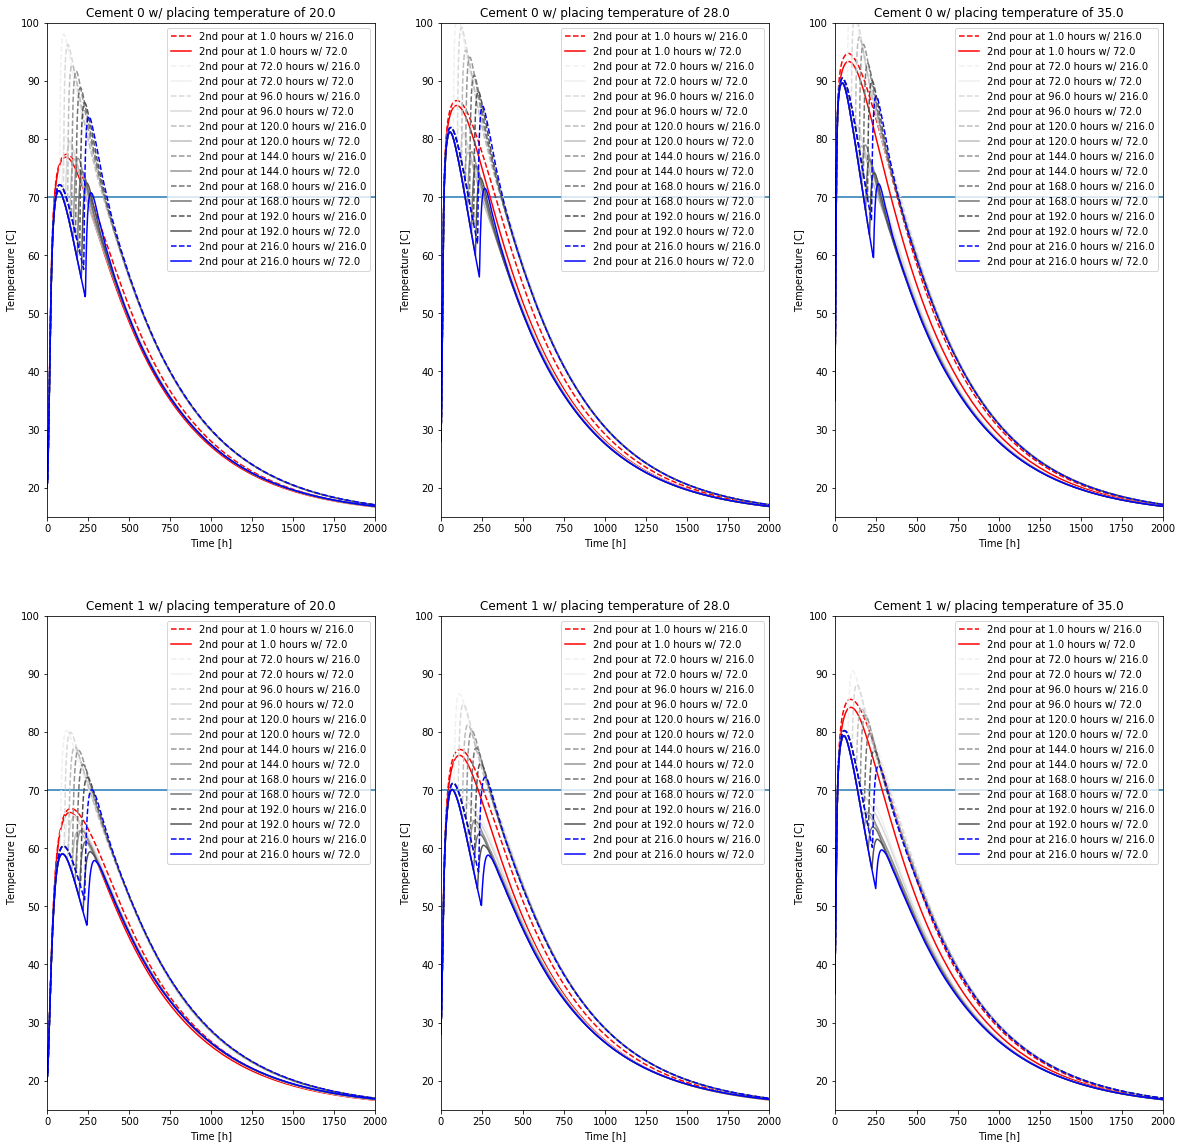

In [104]:
#dataframe to be plot:

#Pot max temperatures
no_cement_id = len(dfs.loc[:,"Cement ID"].unique())
no_plac_temp = len(dfs.loc[:,"Placing Temperature [C]"].unique())
no_files = len(dfs.loc[:,"File"].unique())
no_fw_rem = len(dfs.loc[:,"Fw removed a/ 2nd pr time [h]"].unique())

#Set figure and axes
fig, ax = plt.subplots(no_cement_id,no_plac_temp)
fig.set_figwidth(20)
fig.set_figheight(20)
#fig.suptitle("Tmax")

#Tmax thereshold:
thereshold = 70

#set colour map
no_files_per_analysis = no_files / (no_cement_id * no_plac_temp * no_fw_rem) # number of diff files per analysis
cmap = matplotlib.cm.get_cmap('Greys') # define the colour map
colormap = [cmap(i/float(no_files_per_analysis)) for i in range(0,no_files_per_analysis,1)]  # transform cmap into a list
colormap[0] = (1, 0, 0, 1.0) # set first colour as red
colormap[-1] = (0, 0, 1, 1.0) # set last colour as blue

#set linestyles (-- for 1st pour feature. - for 2nd pour feature)
linestyles = ['--', '-']
markers = ["^", "H"]

#Cycle through CEMENT ID and PLACING TEMPERATURE
for ic, cement in enumerate(dfs.loc[:,"Cement ID"].unique().tolist()):
    for ip, place in enumerate(dfs.loc[:,"Placing Temperature [C]"].unique().tolist()):
        
        #masks:
        mask1 = dfs.loc[:,"Cement ID"] == cement
        mask2 = dfs.loc[:,"Placing Temperature [C]"] == place
        
        #titles:
        ax[ic,ip].set(title = "Cement {} w/ placing temperature of {}".format(int(cement),place))
        ax[ic,ip].set(xlabel = "Time [h]", ylabel = "Temperature [C]")
        ax[ic,ip].axhline(y=thereshold,label = "Tmax")
        
#Cycle through column 2nd pour time [h] - At what time the 2nd pour is done
        for sec_time_i,sec_time in enumerate(dfs.loc[:,"2nd pour time [h]"].unique().tolist()):
            
            #masks:
            mask3 = dfs.loc[:,"2nd pour time [h]"] == sec_time
            
            for fw_i, fw_rem in enumerate(dfs.loc[:,"Fw removed a/ 2nd pr time [h]"].unique().tolist()):
                
                #masks:
                mask4 = dfs.loc[:, "Fw removed a/ 2nd pr time [h]"] == fw_rem
            
                #plot:
                (dfs.loc[(mask1 & mask2 & mask3 & mask4),:]
                    .drop_duplicates(subset=["Time [h]", "Temp [C]", "File"])
                    .sort_values(by=["Time [h]"])
                    .plot(kind = 'line',
                          x = "Time [h]", 
                          y = "Temp [C]",
                          ax = ax[ic,ip],
                          label = "2nd pour at {} hours w/ {}".format(sec_time, fw_rem),
                          color = colormap[sec_time_i],
                          linestyle = linestyles[fw_i],
                          #marker = markers[fw_i]
                         )                                         
                )
                

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 2000)
custom_ylim = (15, 100)

# Setting the values for all axes.
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim);

In [102]:
# #Dataframe 
# df=[]
# for index, row in keymap_maxT.iterrows():
#     mask_1 = keymap.loc[:,"Node"] == row.loc["Node"]
#     mask_2 = keymap.loc[:,"File"] == row.loc["File"]
#     df1 = keymap.loc[mask_1 & mask_2,:]
#     df1.loc[:,"before_after"] = row.loc["2nd pour"]
#     df.append(df1)
# dfs = pd.concat(df)

# #Pot max temperatures
# no_cement_id = len(dfs.loc[:,"Cement ID"].unique())
# no_plac_temp = len(dfs.loc[:,"Placing Temperature [C]"].unique())
# no_files = len(dfs.loc[:,"File"].unique())

# #Set figure and axes
# fig, ax = plt.subplots(no_cement_id,no_plac_temp)
# fig.set_figwidth(20)
# fig.set_figheight(20)
# #fig.suptitle("Tmax")

# #Tmax thereshold:
# thereshold = 70

# #set colour map
# no_files_per_analysis = no_files / (no_cement_id * no_plac_temp) # number of diff files per analysis
# cmap = matplotlib.cm.get_cmap('Greys') # define the colour map
# colormap = [cmap(i/float(no_files_per_analysis)) for i in range(0,no_files_per_analysis,1)]  # transform cmap into a list
# colormap[0] = (1, 0, 0, 1.0) # set first colour as red
# colormap[-1] = (0, 0, 1, 1.0) # set last colour as blue

# #set linestyles (-- for 1st pour feature. - for 2nd pour feature)
# linestyles = ['--', '-']

# #Cycle through CEMENT ID and PLACING TEMPERATURE
# for ic, cement in enumerate(dfs.loc[:,"Cement ID"].unique().tolist()):
#     for ip, place in enumerate(dfs.loc[:,"Placing Temperature [C]"].unique().tolist()):
#         mask1 = dfs.loc[:,"Cement ID"] == cement
#         mask2 = dfs.loc[:,"Placing Temperature [C]"] == place
#         ax[ic,ip].set(title = "Cement {} w/ placing temperature of {}".format(int(cement),place))
#         ax[ic,ip].set(xlabel = "Time [h]", ylabel = "Temperature [C]")
#         ax[ic,ip].axhline(y=thereshold,label = "Tmax")
        
# #Cycle through column 2nd pour time [h] - At what time the 2nd pour is done
#         for sec_time_i,sec_time in enumerate(dfs.loc[:,"2nd pour time [h]"].unique().tolist()):
#             mask3 = dfs.loc[:,"2nd pour time [h]"] == sec_time
#             plot_df = dfs.loc[(mask1 & mask2 & mask3),:]
            
# #Cycle through each node in plot df
#             for node_i,node in enumerate(plot_df.loc[:,"Node"].unique().tolist()):
#                 mask4 = plot_df.loc[:,"Node"] == node
# #                before_after = plot_df.loc[mask4,"before_after"].unique()[0]
#                 feature = plot_df.loc[mask4,"Feature"].unique()[0]
#                 plot_df.loc[mask4,:].plot(kind = 'line', 
#                                           x = "Time [h]", 
#                                           y = "Temp [C]",
#                                           ax = ax[ic,ip],
#                                           label = "{1} 2nd pour at {0} hours in {2} feat.".format(sec_time, before_after,feature),
#                                           color = colormap[sec_time_i],
#                                           linestyle = linestyles[node_i])
#                 #print int(sec_time_i)/7.0                     

# # Defining custom 'xlim' and 'ylim' values.
# custom_xlim = (0, 2000)
# custom_ylim = (15, 95)

# # Setting the values for all axes.
# plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

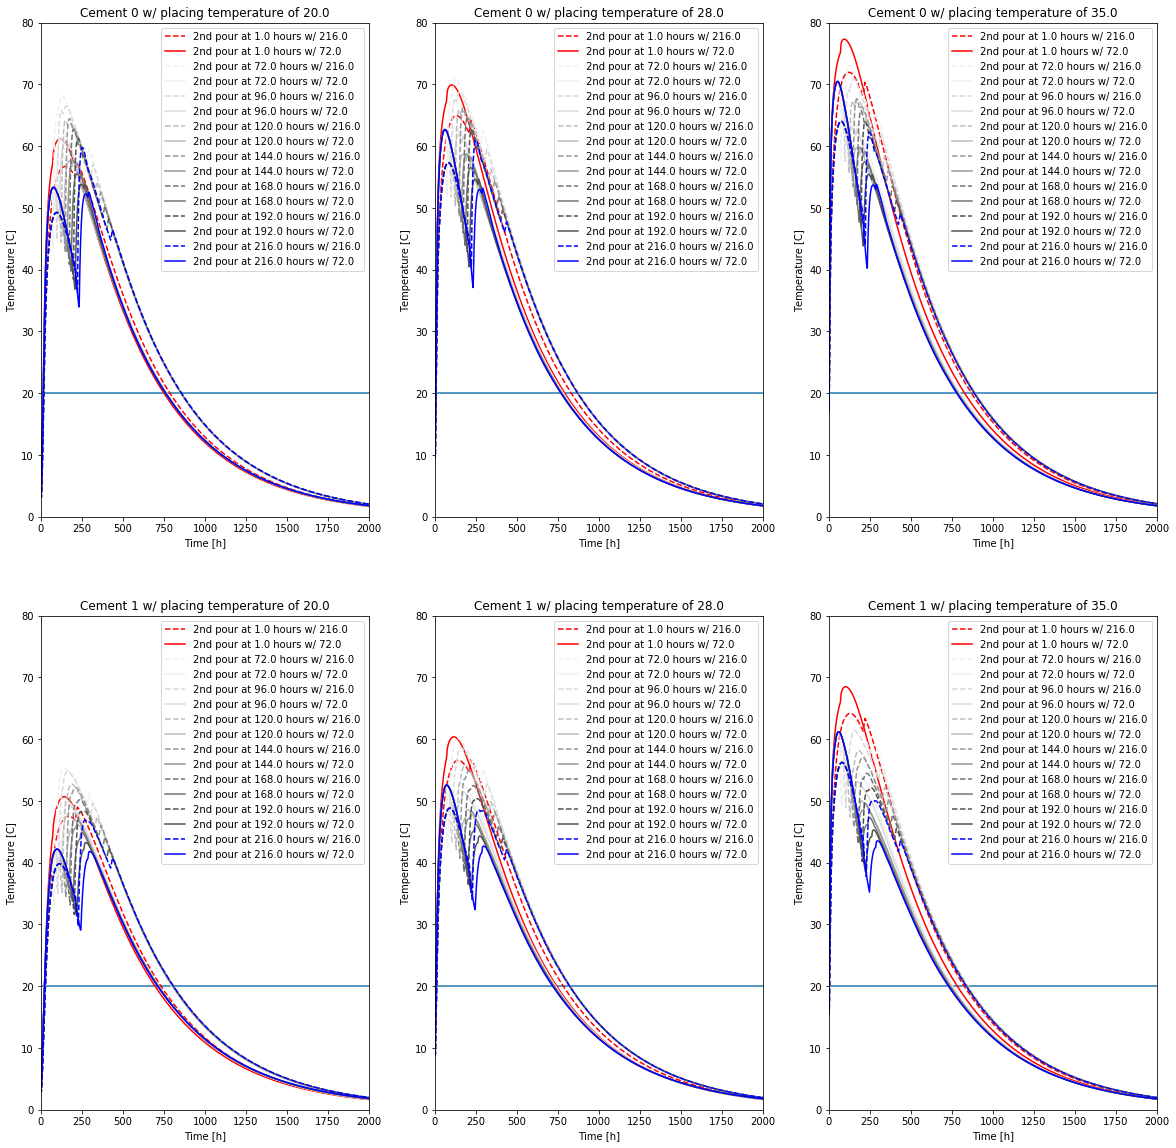

In [105]:
#Dataframe to be plotted:
df_to_plot = DT

#Set figure and axes
fig_DT, ax_DT = plt.subplots(no_cement_id,no_plac_temp)
fig_DT.set_figwidth(20)
fig_DT.set_figheight(20)

#Cycle through CEMENT ID and PLACING TEMPERATURE
for ic, cement in enumerate(df_to_plot.loc[:,"Cement ID"].unique().tolist()):
    for ip, place in enumerate(df_to_plot.loc[:,"Placing Temperature [C]"].unique().tolist()):
        
        #mask:
        mask1 = df_to_plot.loc[:,"Cement ID"] == cement
        mask2 = df_to_plot.loc[:,"Placing Temperature [C]"] == place
        
        #titles:
        ax_DT[ic,ip].set(title = "Cement {} w/ placing temperature of {}".format(int(cement),place))
        ax_DT[ic,ip].set(xlabel = "Time [h]", ylabel = "Temperature [C]")
        ax_DT[ic,ip].axhline(y=20,label = "DTmax")
        
#Cycle through column 2nd pour time [h] - At what time the 2nd pour is done
        for sec_time_i,sec_time in enumerate(df_to_plot.loc[:,"2nd pour time [h]"].unique().tolist()):
            
            #mask:
            mask3 = df_to_plot.loc[:,"2nd pour time [h]"] == sec_time
            
            for fw_i, fw_rem in enumerate(df_to_plot.loc[:,"Fw removed a/ 2nd pr time [h]"].unique().tolist()):
                
                #masks:
                mask4 = df_to_plot.loc[:, "Fw removed a/ 2nd pr time [h]"] == fw_rem
                
                #masked dataframe:
                plot_df = df_to_plot.loc[(mask1 & mask2 & mask3 & mask4),:]

                #plot:
                plot_df.plot(kind = 'line', 
                             x = "Time [h]", 
                             y = "DT [C]",
                             ax = ax_DT[ic,ip],
                             label = "2nd pour at {} hours w/ {}".format(sec_time,fw_rem),
                             color = colormap[sec_time_i],
                             linestyle = linestyles[fw_i]
                             #marker = markers[fw_i]
                            )

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 2000)
custom_ylim = (0, 80)

# Setting the values for all axes.
plt.setp(ax_DT, xlim=custom_xlim, ylim=custom_ylim);